Install `bfsinkhorn` if necessary

In [1]:
%pip install git+https://github.com/DerkKooi/bfsinkhorn

  Cloning https://github.com/DerkKooi/bfsinkhorn to /private/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/pip-req-build-cyu1ije7
  Running command git clone --filter=blob:none --quiet https://github.com/DerkKooi/bfsinkhorn /private/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/pip-req-build-cyu1ije7
  Resolved https://github.com/DerkKooi/bfsinkhorn to commit b1dcc96dc4ea3e1601a93e6317946f8993d380e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bfsinkhorn: filename=bfsinkhorn-0.1.0-py3-none-any.whl size=9077 sha256=efc9606dc00db568846c9c89f06d636c340b318cbe69071b2df21974cdafad45
  Stored in directory: /private/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/pip-ephem-wheel-cache-lenpl9mi/wheels/cb/1a/a2/b2ad6c74ed748579e44c4549f15c28e7ff40270b76ec012c09
Successfully built bfsinkhorn
  Attempting uninstall: bfsinkhorn
    Found existing installation: bfsinkhorn 0.1.0
    Unin

In [1]:
#Toggle saving the figures
save = True

#Numerical tolerance on NOONs for removing them from the calculation
ncut = 10**-12

#Number of Sinkhorn iterations to do before starting Fermionic Sinkhorn
pre_iters = 10

#Try to import bfsinkhorn, if it's not installed, try to import it from the cloned directory
try:
    import bfsinkhorn
except ModuleNotFoundError:
    import sys
    sys.path.append('..')
    import bfsinkhorn

#Import numpy
import numpy as np

#Import jax and set floats to 64-bit
from jax.config import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)

#Import the bosonic and fermionic sinkhorn
from bfsinkhorn.fermion import Sinkhorn as FermionicSinkhorn
from bfsinkhorn.boson import Sinkhorn as BosonicSinkhorn

#Import pyscf modules to do the CISD
from pyscf import gto, scf, ao2mo, ci

#Import xlogy for computing entropies
from scipy.special import xlogy

#Import for plotting and making plots look good
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='sans-serif')
plt.rc('lines', markersize=8)
single_column = 3 + 3/8

/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/ipykernel_46401/3777973098.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])
/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/ipykernel_46401/3777973098.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])


# H $_2$ singlet 

We study the different wavefunction spaces to search over for the H$_2$ singlet and compare the corresponding non-interacting entropy $S_0[n]$ and zeroth-order approximation to the interaction energy $W_0[n]$. Our ground state wavefuntion is CISD in the aug-cc-pVQZ basis.

We start with checking our conversion of the two-electron integrals to the NO basis at equilibrium distance.

In [2]:
#Run ground state calculation at equilibrium geometry
R = 0.742
mol = gto.M(atom=f'''H 0 0 0; H 0 0 {R}''', basis='aug-cc-pVQZ', symmetry=True)
#Run RHF and then CISD
mf = scf.RHF(mol).run()
cisd = ci.CISD(mf).run()

#Compute 1-RDM and one-body part of the energy
rdm1 = cisd.make_rdm1()
norb = rdm1.shape[0]
rdm1_AO = mf.mo_coeff.dot(rdm1.dot(mf.mo_coeff.T))
e_onebody = np.trace(rdm1_AO.dot(mf.get_hcore()))

#Obtain spatial 1-RDM
n, MO_to_NO = np.linalg.eigh(rdm1)

#Test obtaining the 2-electron integrals in the NO basis by recomputing the two-electron energy from the 2-RDM
AO_to_NO = mf.mo_coeff.dot(MO_to_NO)
eri_NO = ao2mo.kernel(mf._eri, AO_to_NO, aosym=1, compact=False).reshape(norb, norb, norb, norb)
rdm2 = cisd.make_rdm2()
rdm2 = np.einsum('ijkl,ip,jq,kr,ls->pqrs',rdm2, MO_to_NO, MO_to_NO, MO_to_NO, MO_to_NO, optimize='optimal')
e_twobody = 1/2*np.einsum('pqrs,pqrs->', rdm2, eri_NO)

#del(eri_NO)
#del(rdm2)
print('These following two should match')
print('CISD energy from pyscf', cisd.e_tot)
print('CISD energy from 2-RDM in NO basis', mf.energy_nuc()+e_onebody+e_twobody)

converged SCF energy = -1.13346068211917
E(RCISD) = -1.173867449447051  E_corr = -0.04040676732788519
These following two should match
CISD energy from pyscf -1.1738674494470511
CISD energy from 2-RDM in NO basis -1.173867449446841


We then check whether the algorithm works for $\mathcal{S}$ (Bosonic Sinkhorn) and $\mathcal{H}_N$ (Fermionic Sinkhorn) at equilibrium geometry.

In [3]:
n_iters = 10
hotstart = 1

N = sum(mol.nelec)
n = jnp.linalg.eigvalsh(rdm1)
n = jnp.flip(n)

#Remove weakly occupied NOs and restore the normalization
n = n[np.where(n > ncut)]
n = n/np.sum(n)*N
norb = n.size

solver = BosonicSinkhorn(N)
solver_old = BosonicSinkhorn(N, old=True)

print("Run the (Bosonic) Sinkhorn for the \mathcal{S} calculation")
result_boson = solver.run_sinkhorn_fixed_iters(n, n_iters=n_iters)
result_boson_old = solver_old.run_sinkhorn_fixed_iters(n, n_iters=n_iters)

#Switch from spatial NOs to spin NOs
ns = np.flip(np.sort(np.concatenate([n, n])/2))
norbs = ns.size

solver = FermionicSinkhorn(N, hotstart=hotstart)
solver_old = FermionicSinkhorn(N, old=True)

print("Run the (Fermionic) Sinkhorn for the \mathcal{H}_N calculation")
result_fermion = solver.run_sinkhorn_fixed_iters(ns, n_iters=n_iters-hotstart)
result_fermion_old = solver_old.run_sinkhorn_fixed_iters(ns, n_iters=n_iters)


Run the (Bosonic) Sinkhorn for the \mathcal{S} calculation
Run the (Fermionic) Sinkhorn for the \mathcal{H}_N calculation


Sinkhorn for $\mathcal{H}_N$ with very few iterations is already converged, so we skip the Fermionic Sinkhorn, entirely in this case. Plot the convergence.

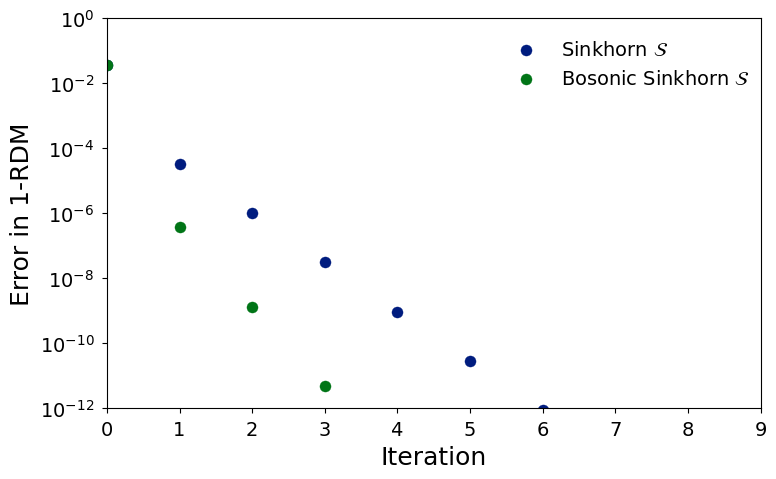

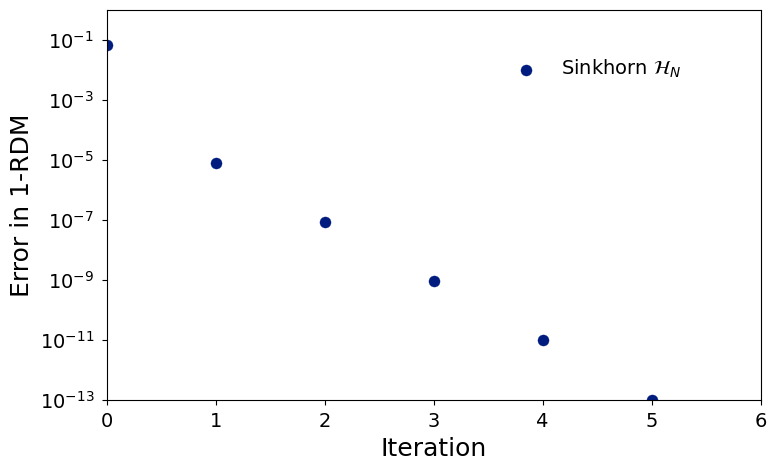

In [4]:
single_column = 3 + 3/8

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_boson_old['n_error'])), result_boson_old['n_error'], label='Sinkhorn $\mathcal{S}$')
plt.scatter(np.arange(len(result_boson['n_error'])), result_boson['n_error'], label='Bosonic Sinkhorn $\mathcal{S}$')
plt.legend(loc=(0.6, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-12, 1)
plt.xlim(0, 9)
plt.show()

single_column = 3 + 3/8

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_fermion_old['n_error'])), result_fermion_old['n_error'], label='Sinkhorn $\mathcal{H}_N$')
plt.legend(loc=(0.6, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-13, 1)
plt.xlim(0, 6)
plt.show()

This works well, so we loop now over the desired bond lengths.

In [5]:
#Set up the potential energy surface with a step size and a number of steps
step = 0.1
Nsteps = 100
R = np.arange(Nsteps)*step

#Create empty arrays for storing the different entropies and energies we want to plot

#\mathcal{S} entropy
S_S2_restricted = np.zeros_like(R)
#\mathcal{S}_z entropy
S_Sz_restricted = np.zeros_like(R)
#\mathcal{H}_N entropy
S_unrestricted = np.zeros_like(R)
#\mathcal{F} entropy
S_GC = np.zeros_like(R)

#Hartree-Fock energy
E_HF = np.zeros_like(R)
#Hartree-fock one-body energy
E_HF_onebody = np.zeros_like(R)
#Hartree-Fock interaction
W_HF = np.zeros_like(R)
#Exact energy
E_CISD = np.zeros_like(R)
#Exact interaction
W_CISD = np.zeros_like(R)
#E onebody
E_onebody = np.zeros_like(R)
#Nuclear energy
E_nuc = np.zeros_like(R)
#\mathcal{S} interaction
W_S2_restricted = np.zeros_like(R)
#\mathcal{S}_z interaction
W_Sz_restricted = np.zeros_like(R)
#\mathcal{H}_N interaction
W_unrestricted = np.zeros_like(R)
#\mathcal{F} interaction
W_GC = np.zeros_like(R)

NOON_error_S2_restricted_axis0 = np.zeros_like(R)
NOON_error_S2_restricted_axis1 = np.zeros_like(R)
NOON_error_unrestricted_axis0 = np.zeros_like(R)
NOON_error_unrestricted_axis1 = np.zeros_like(R)

dm0 = None
ci0 = None

Sinkhorn_S2 = BosonicSinkhorn(2)
Sinkhorn_unrestricted = FermionicSinkhorn(2)

for i in range(R.size):
    print('R:', R[i])
    if i==0:
        #For R=0 take a fake Helium nucleus to avoid the divergence of the internuclear-energy
        mol = gto.M(atom=f'''He''', basis=gto.basis.load('aug-cc-pVQZ', 'H'),  symmetry=True)
    else:
        mol = gto.M(atom=f'''H 0 0 0; H 0 0 {R[i]}''', basis='aug-cc-pVQZ', symmetry=True)
    N = sum(mol.nelec)
    
    #Run Hartree-Fock and CISD
    mf = scf.RHF(mol)
    mf.kernel(dm0=dm0)


    cisd = ci.CISD(mf)
    cisd.kernel(ci0=ci0)

    # Store the initial guess for the next R
    if i > 0:
        dm0 = mf.make_rdm1()
        ci0 = cisd.ci
    
    #Store energies of Hartree-Fock and CISD
    E_HF[i] = mf.e_tot
    E_HF_onebody[i] = np.trace(mf.make_rdm1().dot(mf.get_hcore()))
    E_CISD[i] = cisd.e_tot
    
    #Make 1-RDM, store one-body energy and nuclear energy
    rdm1 = cisd.make_rdm1()
    norb = rdm1.shape[0]
    rdm1_AO = mf.mo_coeff.dot(rdm1.dot(mf.mo_coeff.T))
    E_onebody[i] = np.trace(rdm1_AO.dot(mf.get_hcore()))
    E_nuc[i] = mf.energy_nuc()
    
    #Check our prescriptions for the S and GC with Hartree-Fock
    eri_MO = ao2mo.kernel(mf._eri, mf.mo_coeff, aosym=1, compact=False).reshape(norb, norb, norb, norb)
    J_MO = np.einsum('iijj->ij', eri_MO)
    K_MO = np.einsum('ijji->ij', eri_MO)
    W_HF[i] = 1/2*mf.get_occ().dot(J_MO-1/2*K_MO).dot(mf.get_occ())
    
    #Obtain spatial 1-RDM
    n, MO_to_NO = np.linalg.eigh(rdm1)  
    AO_to_NO = mf.mo_coeff.dot(MO_to_NO)
    
    #Compute coulomb integrals in NO basis
    eri_NO = ao2mo.kernel(mf._eri, AO_to_NO, aosym=1, compact=False).reshape(norb, norb, norb, norb)
    
    #Compute 2-RDM and store CISD interaction energy for check
    rdm2 = cisd.make_rdm2()
    rdm2 = np.einsum('ijkl,ip,jq,kr,ls->pqrs',rdm2, MO_to_NO, MO_to_NO, MO_to_NO, MO_to_NO, optimize='optimal')
    W_CISD[i] = 1/2*np.einsum('pqrs,pqrs->', rdm2, eri_NO)
    del(rdm2)
    
    #Compute J and K matrices
    J = np.einsum('iijj->ij', eri_NO)
    K = np.einsum('ijji->ij', eri_NO)
    del(eri_NO)

    #Remove weakly occupied NOs and restore normalization
    non_zero = np.where(n > ncut)
    n = n[non_zero]
    n = n/np.sum(n)*N
    norb = n.size
    
    #Remove weakly occupied NOs from J and K
    J = J[non_zero].T[non_zero]
    K = K[non_zero].T[non_zero]
    
    #Run Bosonic Sinkhorn for S2 restricted (\mathcal{S})
    result = Sinkhorn_S2(n)
    S_S2_restricted[i] = result['S']
    rdm2_S2_restricted = Sinkhorn_S2.compute_rdm2(n, result['eps'])
    
    NOON_error_S2_restricted_axis0[i] = np.sum(np.abs(np.sum(rdm2_S2_restricted, axis=1)-n))
    NOON_error_S2_restricted_axis1[i] = np.sum(np.abs(np.sum(rdm2_S2_restricted, axis=0)-n))

    
    #print('S2 restricted occupation numbers correct axis 0?', np.allclose(np.sum(rdm2_S2_restricted, axis=1), n))
    #print('S2 restricted occupation numbers correct axis 1?', np.allclose(np.sum(rdm2_S2_restricted, axis=0), n))
    W_S2_restricted[i] = np.trace(rdm2_S2_restricted.dot(J-1/2*K))
    
    #With Sz restricted we just get two separate single-particle problems
    S_Sz_restricted[i] = -2*np.sum(xlogy(n/2,n/2))
    W_Sz_restricted[i] = (n/2).dot(J.dot(n/2))
    
    #Switch from spatial NOs to spin NOs
    ns = np.concatenate([n, n])/2

    #Run the Fermionic sinkhorn for the \mathcal{H}_N calculation
    result_fermion = Sinkhorn_unrestricted(ns)
    S_unrestricted[i] = result_fermion['S']
    rdm2_unrestricted = Sinkhorn_unrestricted.compute_rdm2(ns, result_fermion['eps'])
    #print('Unrestricted occupation numbers correct axis 0?', np.allclose(np.sum(rdm2_unrestricted, axis=1), ns))
    #print('Unrestricted occupation numbers correct axis 1?', np.allclose(np.sum(rdm2_unrestricted, axis=0), ns))
    
    NOON_error_unrestricted_axis0[i] = np.sum(np.abs(np.sum(rdm2_unrestricted, axis=1)-ns))
    NOON_error_unrestricted_axis1[i] = np.sum(np.abs(np.sum(rdm2_unrestricted, axis=0)-ns))
    
    #We only have to compute up-up (aa) and up-down (ab), others follow from symmetry
    rdm2_unrestricted_aa = rdm2_unrestricted[:norb,:norb]
    rdm2_unrestricted_ab = rdm2_unrestricted[:norb,norb:]
    W_unrestricted[i] = np.trace(rdm2_unrestricted_aa.dot(J-K)) + np.trace(rdm2_unrestricted_ab.dot(J))
    
    #Grand canonical entropy and interaction
    S_GC[i] = -2*np.sum(xlogy(n/2, n/2))-2*np.sum(xlogy(1-n/2, 1-n/2))
    W_GC[i] = 1/2*n.dot(J.dot(n))-1/4*n.dot(K.dot(n))

R: 0.0
converged SCF energy = -2.85511900307663
E(RCISD) = -2.894904914972154  E_corr = -0.03978591189552298
R: 0.1
converged SCF energy = 2.52309442068786
E(RCISD) = 2.483037516836615  E_corr = -0.04005690385124785
R: 0.2
converged SCF energy = 0.0463732882924948
E(RCISD) = 0.007031710108939188  E_corr = -0.03934157818355558
R: 0.30000000000000004
converged SCF energy = -0.661298731285523
E(RCISD) = -0.700132809793292  E_corr = -0.03883407850776849
R: 0.4
converged SCF energy = -0.942248124194421
E(RCISD) = -0.9808742238330928  E_corr = -0.03862609963867164
R: 0.5
converged SCF energy = -1.06469738697846
E(RCISD) = -1.103420244597938  E_corr = -0.0387228576194822
R: 0.6000000000000001
converged SCF energy = -1.1162037844227
E(RCISD) = -1.155363076479867  E_corr = -0.03915929205716492
R: 0.7000000000000001
converged SCF energy = -1.13263362433768
E(RCISD) = -1.17259213867226  E_corr = -0.03995851433458153
R: 0.8
converged SCF energy = -1.13076400307547
E(RCISD) = -1.171904076496406  E_

Check if the occupation numbers corresponding to the 2-RDM of the $\mathcal{S}$ and $\mathcal{H}_N$ are decent.

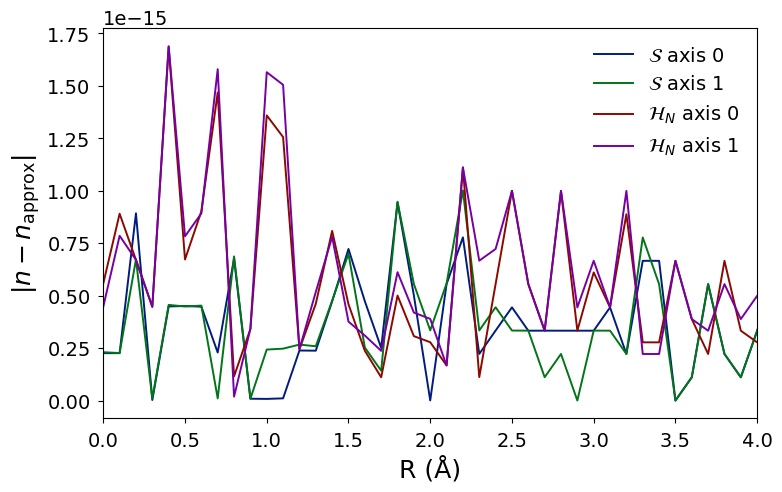

In [6]:
fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.plot(R, NOON_error_S2_restricted_axis0, label='$\mathcal{S}$ axis 0')
plt.plot(R, NOON_error_S2_restricted_axis1, label='$\mathcal{S}$ axis 1')
plt.plot(R, NOON_error_unrestricted_axis0, label='$\mathcal{H}_N$ axis 0')
plt.plot(R, NOON_error_unrestricted_axis1, label='$\mathcal{H}_N$ axis 1')


plt.legend(loc='upper right', framealpha=0)
plt.xlabel('R (Å)')
plt.ylabel('$|n-n_\mathrm{approx}|$')
plt.xlim(0, 4)
plt.show()

# Figure 5: H2 singlet entropy

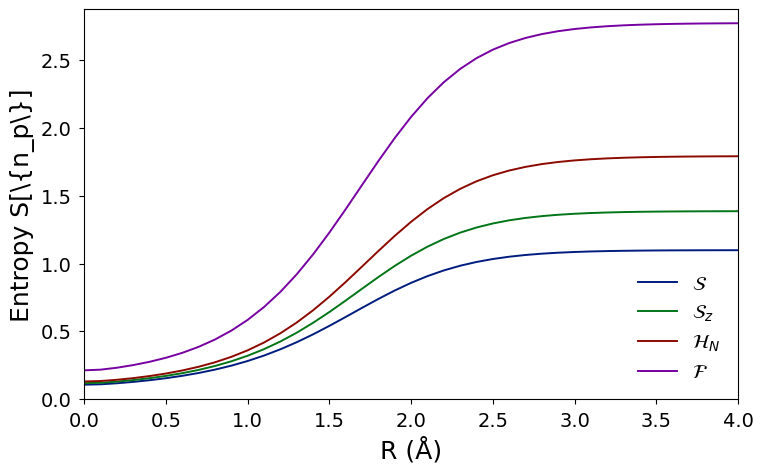

In [7]:
fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.plot(R, S_S2_restricted, label='$\mathcal{S}$')
plt.plot(R, S_Sz_restricted, label='$\mathcal{S}_z$')
plt.plot(R, S_unrestricted, label='$\mathcal{H}_N$')
plt.plot(R, S_GC, label='$\mathcal{F}$')


plt.legend(loc='lower right', framealpha=0)
plt.xlabel('R (Å)')
plt.ylabel('Entropy S[\{n_p\}]')
plt.ylim(0, jnp.max(S_GC)+0.1)
plt.xlim(0, 4)
if save:
    plt.savefig('fig5_H2_singlet_entropy.pdf',
                bbox_inches='tight', 
                transparent=True,
                pad_inches=0.1)
plt.show()

# Figure 6: H2 singlet total energy

Is the Hartree-Fock energy correct? True
Is the CISD energy correct? True


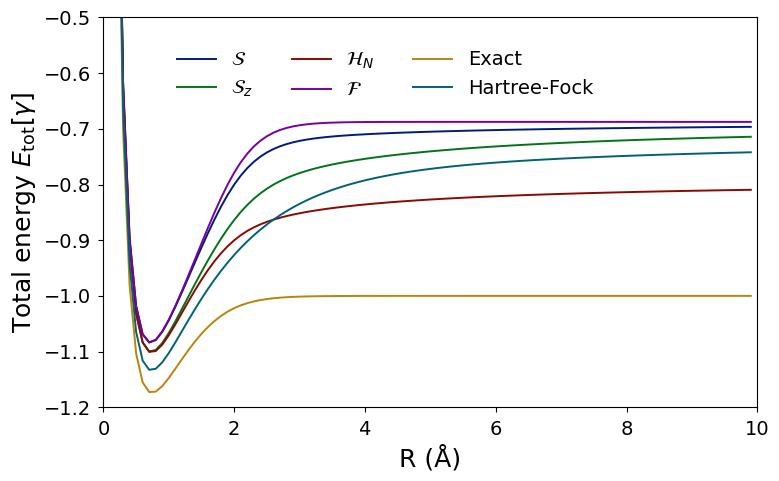

In [8]:
#\mathcal{S} energy
E_S2_restricted = E_onebody + E_nuc + W_S2_restricted
#\mathcal{S}_z energy
E_Sz_restricted = E_onebody + E_nuc + W_Sz_restricted
#\mathcal{H}_N energy
E_unrestricted = E_onebody + E_nuc + W_unrestricted
#\mathcal{F} energy
E_GC = E_onebody + E_nuc + W_GC

#Hartree-Fock energy check
E_HF_check = E_HF_onebody + E_nuc + W_HF
#CISD energy check
E_CISD_check = E_onebody + E_nuc + W_CISD
print('Is the Hartree-Fock energy correct?', np.allclose(E_HF, E_HF_check))
print('Is the CISD energy correct?', np.allclose(E_HF, E_HF_check))

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

#don't plot R=0, since it is infinite due to nuclear contribution
plt.plot(R[1:], E_S2_restricted[1:], label='$\mathcal{S}$')
plt.plot(R[1:], E_Sz_restricted[1:], label='$\mathcal{S}_z$')
plt.plot(R[1:], E_unrestricted[1:], label='$\mathcal{H}_N$')
plt.plot(R[1:], E_GC[1:], label='$\mathcal{F}$')
plt.plot(R[1:], E_CISD[1:], label='Exact', color='C4')
plt.plot(R[1:], E_HF[1:], label='Hartree-Fock', color='C5')

plt.legend(loc=(0.1,0.77), framealpha=0, ncol=3)
plt.xlabel('R (Å)')
plt.ylabel('Total energy $E_\mathrm{tot}[\gamma]$')
plt.xlim(0, step*Nsteps)
plt.ylim(-1.2, -0.5)
if save:
    plt.savefig('fig6_H2_singlet_total_energy.pdf',
                bbox_inches='tight', 
                transparent=True,
                pad_inches=0.1)
plt.show()

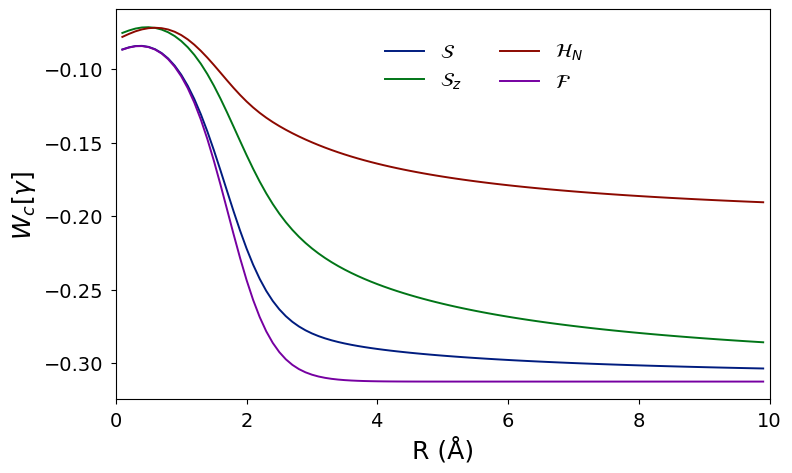

In [9]:
fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.plot(R[1:], E_CISD[1:]-E_S2_restricted[1:], label='$\mathcal{S}$')
plt.plot(R[1:], E_CISD[1:]-E_Sz_restricted[1:], label='$\mathcal{S}_z$')
plt.plot(R[1:], E_CISD[1:]-E_unrestricted[1:], label='$\mathcal{H}_N$')
plt.plot(R[1:], E_CISD[1:]-E_GC[1:], label='$\mathcal{F}$')



plt.legend(loc=(0.4,0.77), framealpha=0, ncol=2)
plt.xlabel('R (Å)')
plt.ylabel('$W_c$[$\gamma$]')
plt.xlim(0, step*Nsteps)
if save:
    plt.savefig('Sfig4_H2_singlet_correlation_energy.pdf',
                bbox_inches='tight', 
                transparent=True,
                pad_inches=0.1)
plt.show()